In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display

In [2]:
df = pd.read_csv('DSET\Dublin IRE AQI.csv')

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NO,31347.0,11.741025,13.109726,-13.87,3.46,7.61,15.280,112.92
PM10,31347.0,11.567853,9.914649,0.00,5.90,9.37,14.495,421.52
PM2.5,31347.0,7.366711,7.895451,0.00,3.27,5.34,8.845,309.19
AQI,31347.0,28.201678,21.504215,0.00,14.00,22.00,37.000,348.00


In [3]:
df.head(3)

,time,NO,PM10,PM2.5,AQI
0,2020-06-30 1:00,-0.47,4.93,3.45,14
1,2020-06-30 2:00,-0.67,3.38,2.17,9
2,2020-06-30 3:00,-0.72,5.57,3.18,13


<Axes: >

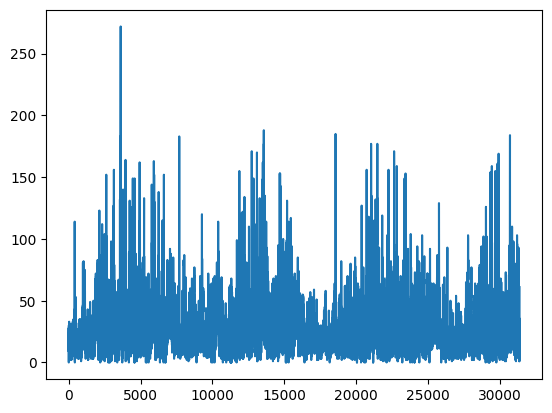

In [6]:
aqi = df['AQI']
bad_aqi = aqi == -999
aqi[bad_aqi] = df['AQI'].mean()
bad_aqi = aqi == np.max(aqi)
aqi[bad_aqi] = df['AQI'].mean()
IPython.display.clear_output()
aqi.plot()

## Fourier Transform
สามารถระบุความถี่ที่สำคัญได้โดยการแยกคุณลักษณะต่างๆ ด้วย Fast Fourier Transform 

หากต้องการตรวจสอบสมมติฐาน คือ tf.signal.rfft ของ AQI ในช่วงเวลาหนึ่ง สังเกตจุดสูงสุดที่ชัดเจนที่ความถี่ใกล้ 1/year และ 1/day

### การอธิบายโค้ดสำหรับรายงาน

โค้ดด้านล่างนี้ใช้ TensorFlow และ numpy เพื่อทำการแปลงสัญญาณทางคลื่นจากโทรศัพท์มือถือในรูปแบบของอากาศที่คุณสามารถวัดคุณภาพของอากาศ (AQI - Air Quality Index) ให้อยู่ในโดเมนความถี่ที่เข้าใจได้ง่าย เพื่อทำการนำเสนอผลข้อมูลในรายงานอย่างกระชับและเข้าใจได้ง่าย

```python
tf.signal.rfft(df['AQI']) ทำการใช้ TensorFlow เพื่อคำนวณ Fast Fourier Transform (FFT) ของข้อมูล AQI เพื่อแปลงข้อมูลให้อยู่ในโดเมนความถี่
np.arange(0, len(fft)) สร้าง array ของค่าความถี่ตามข้อมูล FFT
np.abs(fft) ทำการคำนวณค่าสัมบูรณ์ของ FFT เพื่อให้ได้ค่าที่เป็นบวก
plt.step() พล็อตผลข้อมูลในรูปแบบของกราฟ step
plt.xscale('log') กำหนดให้แกน x เป็นล็อกสเกล
plt.ylim(0, 100000) กำหนดขอบเขตสูงสุดและต่ำสุดของแกน y
plt.xlim([0.1, max(plt.xlim())]) กำหนดขอบเขตสูงสุดและต่ำสุดของแกน x
plt.xticks([1, 365.2524], labels=['1/Year', '1/day']): กำหนดเส้นแกน x และตั้งชื่อให้เป็น '1/Year' และ '1/day'
plt.xlabel('Frequency (log scale)'): กำหนดชื่อแกน x เป็น 'Frequency (log scale)'

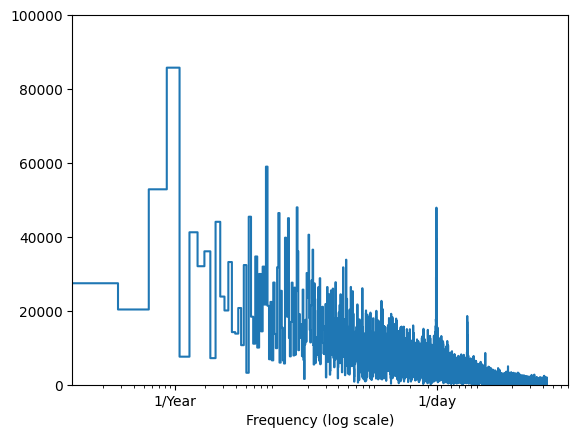

In [7]:
fft = tf.signal.rfft(df['AQI'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['AQI'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [8]:
aqi.shape[0]

31347

## Data Windowing

แบบจำลองจะสร้างชุด forecasting โดยอิงตาม Window ตัวอย่างที่ต่อเนื่องกันจากข้อมูล

คุณสมบัติหลักของหน้าต่างอินพุตคือ
- The width (number of time steps) ของ input และ label windows.
- The time offset.
- Which features are used as inputs, labels, or both.

สร้างโมเดล (RNN, LSTM, Dense):
การทำนายเอาต์พุตเดี่ยว
การทำนายขั้นตอนเดียว

ในส่วนนี้เน้นที่การนำ data windowing ไปใช้เพื่อให้สามารถนำมาใช้ซ้ำกับโมเดลเหล่านั้นทั้งหมดได้

ขึ้นอยู่กับงานและประเภทของโมเดล อาจต้องการสร้าง window ข้อมูลที่หลากหลาย นี่คือตัวอย่างบางส่วน

- [[[1], [2], [3], [4], [5]]] -> [6]
- [[[2], [3], [4], [5], [6]]] -> [7]
- [[[3], [4], [5], [6], [7]]] -> [8]
- ...

สร้างลำดับจากข้อมูลของเรา 

In [9]:
def windows(df, window_size = 21):
    df_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_np)-window_size):
        row = [[a] for a in df_np[i:i+window_size]]
        x.append(row)
        label = df_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y)

WINDOWS_SIZE = 500

x, y = windows(aqi, WINDOWS_SIZE)

In [10]:
x.shape, y.shape

((30847, 500, 1), (30847,))

## Train Test Split and Validate data

กำหนดขนาดของข้อมูลที่ใช้ Training Models

การแบ่งข้อมูลสำหรับการฝึกอบรม (train), ทดสอบ (test), และการตรวจสอบความถูกต้อง (validate) โดยให้ขนาดของแต่ละส่วนเป็นสัดส่วนดังนี้:

- ขนาดสำหรับการฝึกอบรม (train_size) เป็น 85%
- ขนาดสำหรับการทดสอบ (test_size) เป็น 10%
- ขนาดสำหรับการตรวจสอบความถูกต้อง (validate_size) เป็น 5%

จากนั้นมีการทำการแบ่งข้อมูลตามสัดส่วนดังกล่าวเพื่อให้ได้ x_train, y_train, x_val, y_val, x_test, และ y_test โดยมีการใช้ฟังก์ชัน slicing บน list โดยใช้ขนาดของข้อมูลและสัดส่วนที่กำหนดไว้ และนำไปเก็บในตัวแปรต่าง ๆ สำหรับการใช้งานต่อไป.


In [11]:
train_size = 0.85
test_size = 0.1
validate_size = 0.05


x_train, y_train = x[:int(len(x)*train_size)], y[:int(len(y)*train_size)]
x_val, y_val = x[int(len(x)*train_size): int(len(x)*train_size)+ int(len(x)*validate_size)], y[int(len(y)*train_size): int(len(y)*train_size)+ int(len(y)*validate_size)]
x_test, y_test = x[int(len(x)*train_size)+ int(len(x)*validate_size): ], y[int(len(y)*train_size)+ int(len(y)*validate_size): ]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((26219, 500, 1), (26219,), (1542, 500, 1), (1542,), (3086, 500, 1), (3086,))

### Import the Library to Training the models

In [12]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.activations import *
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

## Generate the model

![Alt Text](image_t\lstm.png)

In [13]:
model = Sequential()
model.add(InputLayer((WINDOWS_SIZE,1)))
model.add(LSTM(16))
model.add(Dense(64, relu))
model.add(Dense(1, linear))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


### การตั้งค่า Early Stopping ในการ Train Model

ในการฝึกโมเดลเครื่องศักย์เรียน, สิ่งสำคัญคือการป้องกันการ overfitting และเพิ่มประสิทธิภาพ วิธีหนึ่งที่นิยมใช้คือการใช้ Early Stopping 

ซึ่งหยุดกระบวนการฝึกเมื่อประสิทธิภาพของโมเดลบนชุด validation ไม่ดีขึ้นหลังจากจำนวน epoch ที่กำหนด

นี่คือวิธีการนำ Early Stopping มาใช้ใน Python โดยใช้ Keras:


```python
patience = 2  # กำหนดค่า patience สำหรับ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')


คอมไพล์โมเดล

หลังจากการตั้งค่า Early Stopping เสร็จสิ้น, ขั้นตอนต่อไปคือคอมไพล์โมเดล 
การคอมไพล์จะกำหนดค่าให้โมเดลสำหรับการฝึกและระบุการตั้งค่าเช่นฟังก์ชัน loss , test และ validate


model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])


loss: กำหนดฟังก์ชันสูญเสียที่จะใช้ในระหว่างการฝึก ในที่นี้ใช้ Mean Squared Error (MSE) ซึ่งเป็นวิธีที่นิยมใช้สำหรับปัญหาการ regression และคำนวณค่าเฉลี่ยของความต่างกำลังสองระหว่างค่าที่พยากรณ์และค่าจริง

optimizer: กำหนดอัลกอริทึมการปรับของค่าให้ใช้ในการลดค่าของฟังก์ชันสูญเสีย ในที่นี้ใช้ Adam optimizer ที่เป็นอัลกอริทึมการปรับอัตราการเรียนรู้ที่ปรับได้และมีประสิทธิภาพ

metrics: เป็นรายการของเมตริกที่จะให้โมเดลประเมินระหว่างการฝึกและทดสอบ ในที่นี้รวม MAE (Mean Absolute Error) ซึ่งคำนวณค่าเฉลี่ยของความแตกต่างค่าสัมบูรณ์ระหว่างค่าที่พยากรณ์และค่าจริง เป็นเมตริกที่ให้ข้อมูลเกี่ยวกับความคลาดเคลื่อนของการพยากรณ์

In [14]:
patience = 2
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])


### การ Train Model

เมื่อตั้งค่าและคอมไพล์โมเดลเสร็จสิ้น, ขั้นตอนต่อไปคือการฝึกโมเดลโดยใช้ข้อมูลฝึกและการตรวจสอบความถูกต้อง

นี่คือวิธีการฝึกโมเดล:

```python
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, callbacks=[early_stopping])


In [15]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, callbacks=[early_stopping]) #
IPython.display.clear_output()
model.save('model_checkpoint.h5')

### การทำนาย

In [16]:
pred = model.predict(x_test).flatten()
train_result = pd.DataFrame({'Pred': pred, 'Actual': y_test})

97/97 [==============================] - 2s 16ms/step


### การทำนายล้วงหน้า

การทำนายล้วงหน้า (Forecasting) เป็นกระบวนการที่ใช้โมเดลที่ฝึกสอนด้วยข้อมูลที่มีอยู่เพื่อทำนายค่าในอนาคต

นี่คือวิธีการทำนายล้วงหน้าในโค้ด Python:

```python
y_pred = np.array([]).astype(np.int64)

for i in range(12):
    pred = model.predict(x_test).flatten()
    print(pred[-1])
    d_train = np.concatenate((x_test[-1][1:], np.array([np.int64([pred[-1]])])), axis=0)
    x_test = np.concatenate((x_test, [d_train]), axis=0)
    y_pred = np.append(y_pred, np.int64(pred[-1]))
    print(x_test[-1])
    y_pred = np.append(y_pred, pred[-1])

IPython.display.clear_output()

y_pred: เป็น array ที่ใช้เก็บค่าที่ทำนายได้ โดยเริ่มต้นเป็น array ว่าง

สำหรับทุกครั้งที่วน loop จำนวน 12 ครั้ง หรือหมายถคง ทำนายล่วงหน้าไป 12 ชั่วโมงจาก Sequence dataset:

pred = model.predict(x_test).flatten(): ทำการทำนายผลลัพธ์จากโมเดลโดยใช้ข้อมูลทดสอบและแปลงเป็น array 1 มิติ

d_train = np.concatenate((x_test[-1][1:], np.array([np.int64([pred[-1]])])), axis=0) คือ สร้างข้อมูลใหม่โดยเอาข้อมูลที่มีอยู่และค่าที่ทำนายได้ล่าสุดมาเป็นข้อมูลใหม่
x_test = np.concatenate((x_test, [d_train]), axis=0) คือ เพิ่มข้อมูลใหม่เข้าไปในชุดข้อมูลทดสอบ
y_pred = np.append(y_pred, np.int64(pred[-1])) คือ เพิ่มค่าที่ทำนายได้ล่าสุดลงใน array ที่เก็บผลลัพธ์

การทำนายล้วงหน้าใช้โมเดลที่ฝึกสอนเพื่อทำนายค่าในอนาคตโดยใช้ข้อมูลที่มีอยู่ในชุดข้อมูลทดสอบและการวนลูปเพื่อทำนายค่าต่อเนื่องๆ จนครบจำนวนที่ต้องการ

In [19]:
y_pred = np.array([]).astype(np.int64)

for i in range(12):
    pred = model.predict(x_test).flatten()
    print(pred[-1])
    d_train = np.concatenate((x_test[-1][1:], np.array([np.int64([pred[-1]])])), axis=0)
    x_test = np.concatenate((x_test, [d_train]), axis=0)
    y_pred = np.append(y_pred, np.int64(pred[-1]))
    print(x_test[-1])
    y_pred = np.append(y_pred, pred[-1])
IPython.display.clear_output()


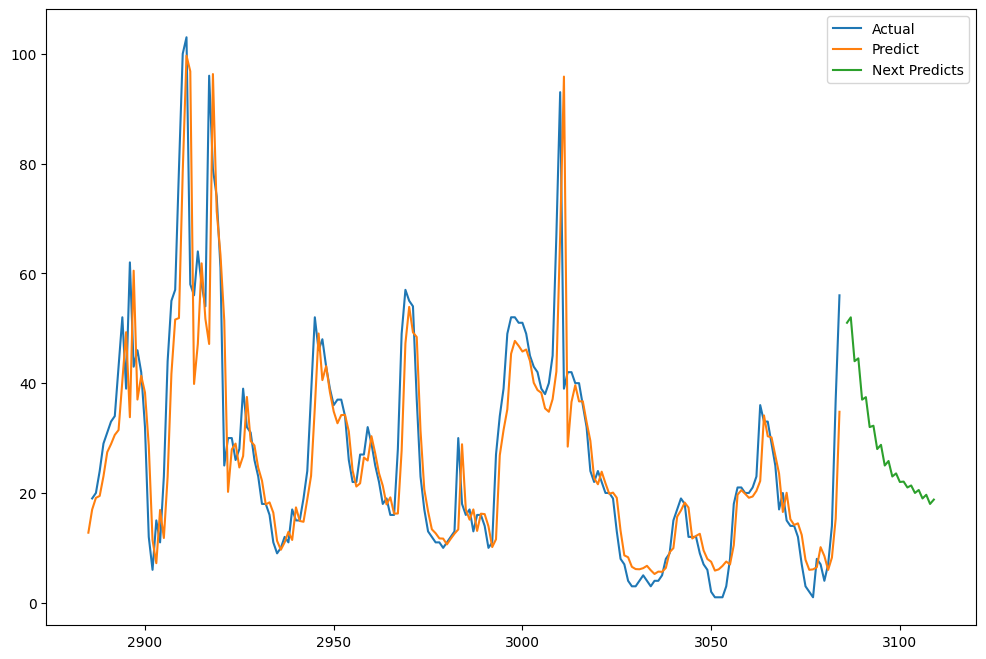

In [20]:
M = -200
N = -1

plt.figure(figsize=(12,8))
plt.plot(train_result['Actual'][M:N], label='Actual')
plt.plot(train_result['Pred'][M-1:N], label= 'Predict')
plt.plot(np.arange(len(train_result), len(train_result) + len(y_pred)), y_pred, label='Next Predicts')
plt.legend()
plt.show()